In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

num_classes = 4
num_features = 2
random_seed = 1

X, y = make_blobs(n_samples=10000, n_features=num_features, centers=num_classes, 
                  cluster_std=1.5, random_state=random_seed)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [2]:
import seaborn as sns

class SimpleModel(torch.nn.Module):
    def __init__(self,input_size, output_size):
        
        super(SimpleModel,self).__init__()
        self.fc1 = nn.Linear(input_size,11)
        self.fc2 = nn.Linear(11, out_features=output_size)
        
    def forward(self, x):
        
        x = torch.relu(self.fc1(x))
        x = (self.fc2(x))
        return x

In [3]:
def train_step(model, X_train, y_train, loss_fn, optimizer, device):
    
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_hat = model(X_train)
    loss = loss_fn(y_hat, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        _, test_pred = torch.max(y_hat,dim=1)
    
    train_acc = (test_pred == y_train).sum().item() / len(y_train)
    return loss.item(), train_acc

In [4]:
def evaluation_step(model, X_test, y_test, loss_fn, device):
    
    X_test, y_test = X_test.to(device), y_test.to(device)
    with torch.no_grad():
        outputs = model(X_test)
        loss = loss_fn(outputs, y_test).item()
        _, y_pred = torch.max(outputs,dim=1)
    
    accuracy = (y_pred == y_test).sum().item() / len(y_test)
    return loss, accuracy

In [5]:
def train_simple_model(X_train, y_train, X_test, y_test, random_seed):
    
    device = "cpu" 
    if torch.cuda.is_available(): 
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps" 
    
    torch.manual_seed(random_seed)


    model = SimpleModel(input_size=X_train.shape[1], output_size=len(torch.unique(y_train))).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    loss_func = nn.CrossEntropyLoss()

    ne_s = 55
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    for e in range(ne_s):
        
        model.train()
        train_loss, train_accuracy = train_step(model, X_train, y_train, loss_func, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        test_loss, test_accuracy = evaluation_step(model, X_test, y_test, loss_func, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        if e % 5 == 0:
            print("Epoch:", e)
            print("Train Loss:", train_loss, "Train Acc:", train_accuracy, "Test Loss:", test_loss, "Test Acc:", test_accuracy)
            print("="*75)


    return model, train_losses, train_accuracies, test_losses, test_accuracies

In [6]:
def plot_accuracy_performance(train_accuracies, test_accuracies):
    
    sns.lineplot(train_accuracies, label = 'Train Accuracy')
    sns.lineplot(test_accuracies, label = 'Test Accuracy')
    plt.title("Accuracy by Epoch")
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [7]:
def plot_loss_performance(train_losses, test_losses):
    
    sns.lineplot(train_losses, label = 'Train Loss')
    sns.lineplot(test_losses, label = 'Test Loss')
    plt.title("Loss by Epoch")
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [8]:
def plot_decision_boundary(model, X_train, y_train):
    
    device = "cpu" 
    if torch.cuda.is_available(): 
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps" 

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points = torch.tensor(grid_points, dtype=torch.float32)
    grid_points = grid_points.to(device)
    temp = model(grid_points).cpu().detach().numpy()
    temp = np.argmax(temp, axis=1)
    temp = temp.reshape(xx.shape)

    plt.contourf(xx, yy, temp, cmap="Spectral", alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Spectral")
    plt.title("Decision boundary with the training set")
    plt.xlabel("1st Feat.")
    plt.ylabel("2nd Feat.")
    plt.show()

In [9]:
model, train_losses, train_accuracies, test_losses, test_accuracies\
    = train_simple_model(X_train, y_train, X_test, y_test, random_seed)

Epoch: 0
Train Loss: 1.3614368438720703 Train Acc: 0.463125 Test Loss: 0.7843761444091797 Test Acc: 0.6635
Epoch: 5
Train Loss: 0.5324997305870056 Train Acc: 0.679 Test Loss: 0.49289366602897644 Test Acc: 0.738
Epoch: 10
Train Loss: 0.4476158022880554 Train Acc: 0.75875 Test Loss: 0.4060591757297516 Test Acc: 0.83
Epoch: 15
Train Loss: 0.39206740260124207 Train Acc: 0.840625 Test Loss: 0.37251612544059753 Test Acc: 0.8345
Epoch: 20
Train Loss: 0.37203237414360046 Train Acc: 0.860625 Test Loss: 0.34876111149787903 Test Acc: 0.876
Epoch: 25
Train Loss: 0.3256193995475769 Train Acc: 0.875125 Test Loss: 0.3089978098869324 Test Acc: 0.8885
Epoch: 30
Train Loss: 0.2855204641819 Train Acc: 0.893125 Test Loss: 0.26734188199043274 Test Acc: 0.9085
Epoch: 35
Train Loss: 0.25271719694137573 Train Acc: 0.906375 Test Loss: 0.24517011642456055 Test Acc: 0.909
Epoch: 40
Train Loss: 0.23291002213954926 Train Acc: 0.9125 Test Loss: 0.22216151654720306 Test Acc: 0.9155
Epoch: 45
Train Loss: 0.2226248532

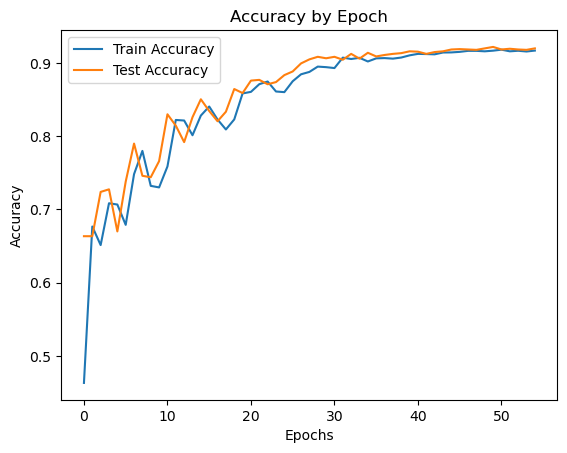

In [10]:
plot_accuracy_performance(train_accuracies, test_accuracies)

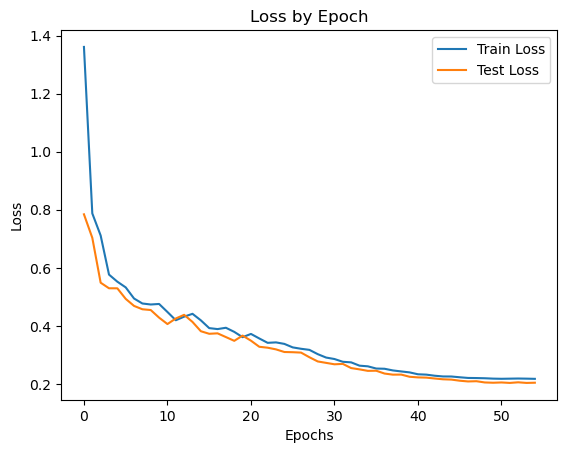

In [11]:
plot_loss_performance(train_losses, test_losses)

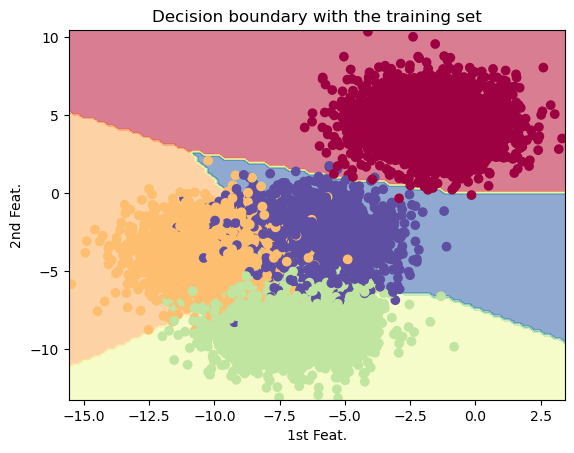

In [12]:
plot_decision_boundary(model, X_train, y_train)